In [1]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00


In [2]:
#Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [3]:
holidays = pd.read_csv('/content/holidays_events.csv',parse_dates=['date'])
oil = pd.read_csv('/content/oil.csv',parse_dates=['date'])
stores = pd.read_csv('/content/stores.csv')
transactions = pd.read_csv('/content/transactions.csv',parse_dates=['date'])

In [4]:
train = pd.read_csv('/content/train.csv',parse_dates=['date'])
test = pd.read_csv('/content/test.csv',parse_dates=['date'])

In [5]:
def select_sample(df, n=10000):
    if df is not None and len(df) > n:
        return df.sample(n=n, random_state=42)  # Random sample of 10,000 rows
    return df

oil = select_sample(oil, 100000)
holidays = select_sample(holidays, 100000)
stores = select_sample(stores, 100000)
train_sampled = select_sample(train, 100000)
transactions = select_sample(transactions, 100000)
test = select_sample(test, 100000)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [6]:
# Step 1: Rename 'type' to 'holiday_type' in data_holidays
holidays = holidays.rename(columns={'type': 'holiday_type'})
print("\nColumns in data_holidays after renaming:")
print(holidays.columns)

# Step 2: Feature Engineering - Create date-related features
for data in [oil, holidays, train, transactions, test]:
    if 'date' in data.columns:
        data['year'] = data['date'].dt.year
        data['month'] = data['date'].dt.month
        data['day'] = data['date'].dt.day
        data['day_of_week'] = data['date'].dt.dayofweek
        data['day_name'] = data['date'].dt.strftime('%A')

# Step 3: Merge datasets
# Merge oil data
train = train.merge(oil[['date', 'dcoilwtico']], on='date', how='left')
test = test.merge(oil[['date', 'dcoilwtico']], on='date', how='left')
oil = oil.drop(columns=['dcoilwtico'])

# Merge holidays data
train = train.merge(
    holidays,
    on=['date', 'day', 'month', 'year', 'day_of_week', 'day_name'],
    how='left'
)
test = test.merge(
    holidays,
    on=['date', 'day', 'month', 'year', 'day_of_week', 'day_name'],
    how='left'
)

# Merge stores data
train = train.merge(
    stores.rename(columns={'type': 'store_type'}),
    on='store_nbr',
    how='left'
)
test = test.merge(
    stores.rename(columns={'type': 'store_type'}),
    on='store_nbr',
    how='left'
)

# Merge transactions data
train = train.merge(
    transactions,
    on=['date', 'store_nbr', 'day', 'month', 'year', 'day_of_week', 'day_name'],
    how='left'
)
test = test.merge(
    transactions,
    on=['date', 'store_nbr', 'day', 'month', 'year', 'day_of_week', 'day_name'],
    how='left'
)

# Step 4: Aggregate sales across all stores
data_agg = train.groupby('date').agg({
    'sales': 'sum',
    'dcoilwtico': 'mean',
    'transactions': 'mean'
}).reset_index()

# Step 5: Merge holiday information
holidays = holidays[holidays['locale'] == 'National']  # Considering only national holidays
print("\nColumns in holidays DataFrame:")
print(holidays.columns)

# Ensure 'holiday_type' exists before selecting
if 'holiday_type' in holidays.columns:
    data_agg = data_agg.merge(
        holidays[['date', 'holiday_type']],
        on='date',
        how='left'
    )
    print("Merged 'holiday_type' successfully.")
else:
    print("Error: 'holiday_type' column does not exist in holidays DataFrame.")

# Step 6: Handle missing values
data_agg['holiday_type'].fillna('None', inplace=True)
data_agg['dcoilwtico'].fillna(method='ffill', inplace=True)
data_agg['transactions'].fillna(method='ffill', inplace=True)

# Step 7: Feature Engineering - Additional time-based features
data_agg['year'] = data_agg['date'].dt.year
data_agg['month'] = data_agg['date'].dt.month
data_agg['day'] = data_agg['date'].dt.day
data_agg['day_of_week'] = data_agg['date'].dt.dayofweek
data_agg['day_name'] = data_agg['date'].dt.strftime('%A')

# Step 8: Encode categorical variables
data_agg = pd.get_dummies(data_agg, columns=['holiday_type', 'day_name'], drop_first=True)

# Step 9: Set date as index
data_agg.set_index('date', inplace=True)

# Step 10: Verify the first few rows of the aggregated data
print("\nAggregated Data:")
print(data_agg.head())



Columns in data_holidays after renaming:
Index(['date', 'holiday_type', 'locale', 'locale_name', 'description',
       'transferred'],
      dtype='object')

Columns in holidays DataFrame:
Index(['date', 'holiday_type', 'locale', 'locale_name', 'description',
       'transferred', 'year', 'month', 'day', 'day_of_week', 'day_name'],
      dtype='object')
Merged 'holiday_type' successfully.

Aggregated Data:
                    sales  dcoilwtico  transactions  year  month  day  \
date                                                                    
2013-01-01    2511.618999         NaN    770.000000  2013      1    1   
2013-01-02  496092.417944       93.14   2026.413043  2013      1    2   
2013-01-03  361461.231124       92.97   1706.608696  2013      1    3   
2013-01-04  354459.677093       93.12   1706.391304  2013      1    4   
2013-01-05  477350.121229       93.12   2034.195652  2013      1    5   

            day_of_week  holiday_type_Event  holiday_type_Holiday  \
date    

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   year          int32         
 7   month         int32         
 8   day           int32         
 9   day_of_week   int32         
 10  day_name      object        
 11  dcoilwtico    float64       
 12  holiday_type  object        
 13  locale        object        
 14  locale_name   object        
 15  description   object        
 16  transferred   object        
 17  city          object        
 18  state         object        
 19  store_type    object        
 20  cluster       int64         
 21  transactions  float64       
dtypes: datetime64[ns](1), float64(3), int32(4), int64(4), object(10)
m

In [7]:
# Step 1: Split the data into training and testing sets based on time
# We'll use the last 30 days for testing
split_date = data_agg.index.max() - pd.Timedelta(days=30)
train_data = data_agg[data_agg.index <= split_date]
test_data = data_agg[data_agg.index > split_date]

print(f"Training data from {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data from {test_data.index.min()} to {test_data.index.max()}")

# Step 2: Define the target variable and exogenous variables
y_train = train_data['sales']
X_train = train_data.drop(columns=['sales'])

y_test = test_data['sales']
X_test = test_data.drop(columns=['sales'])

from statsmodels.tsa.stattools import adfuller
result = adfuller(data_agg['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


Training data from 2013-01-01 00:00:00 to 2013-08-28 00:00:00
Testing data from 2013-08-29 00:00:00 to 2013-09-27 00:00:00
ADF Statistic: -3.210415277655733
p-value: 0.01938966239210922


In [12]:
# Step 3: Automatically determine the optimal SARIMA parameters
# Note: auto_arima can take time depending on data size
stepwise_model = auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)


print("\nSARIMA Model Summary:")
print(stepwise_model.summary())

# Step 4: Make predictions on the test set
forecast = stepwise_model.predict(n_periods=len(test_data), exogenous=X_test)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6132.011, Time=1.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6248.425, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6221.956, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6167.957, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6246.459, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6132.207, Time=2.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6130.025, Time=2.16 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6150.022, Time=0.32 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=6131.319, Time=2.23 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=3.82 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=6147.911, Time=0.41 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=6143.249, Time=0.39 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=6129.631, Time=0.78 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=6151.116, Time=0.36 sec
 ARIMA(3,1,2)(2,0,0)[12]


Model Evaluation Metrics:
Mean Squared Error (MSE): 6294459670.22
Root Mean Squared Error (RMSE): 79337.63
Mean Absolute Error (MAE): 54732.66
R-squared (R²): 0.51


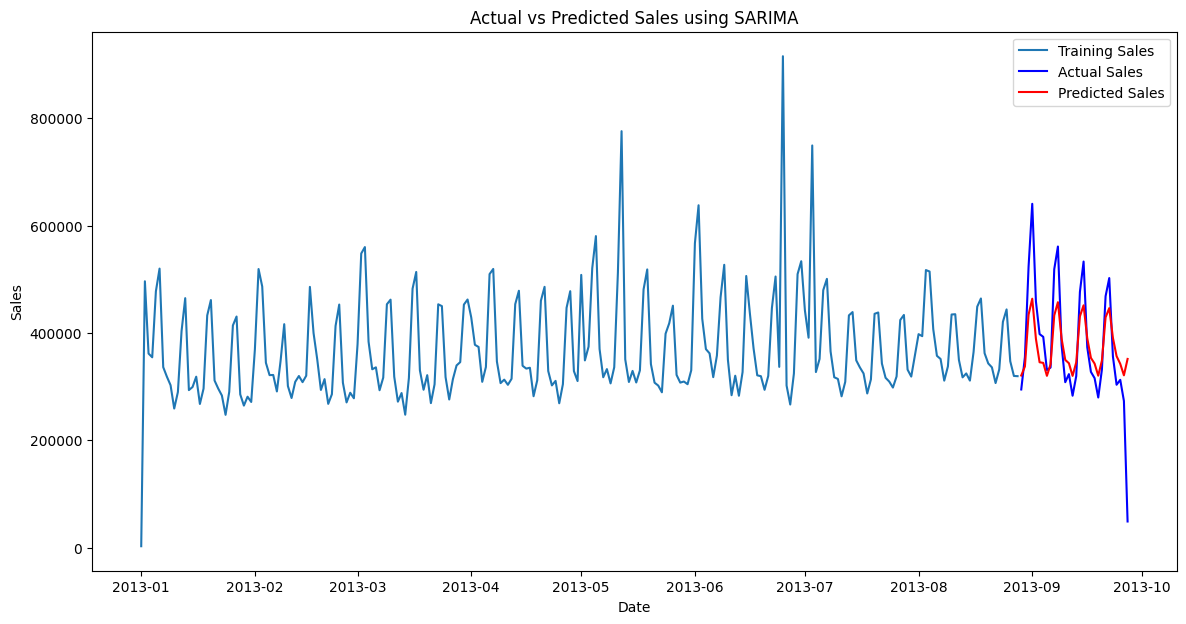

In [13]:
# Step 5: Evaluate the model
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, forecast)
r2 = r2_score(y_test, forecast)

print(f"\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Step 6: Plot Actual vs Predicted Sales
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, y_train, label='Training Sales')
plt.plot(test_data.index, y_test, label='Actual Sales', color='blue')
plt.plot(test_data.index, forecast, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales using SARIMA')
plt.legend()
plt.show()